In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering, Birch, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df=pd.read_csv("data/processed/processed_online_retail_II.csv")
df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])

### Exploratory Data Analysis (EDA)

In [3]:
# DataFrame Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779495 non-null  int64         
 1   StockCode    779495 non-null  object        
 2   Description  779495 non-null  object        
 3   Quantity     779495 non-null  int64         
 4   InvoiceDate  779495 non-null  datetime64[ns]
 5   Price        779495 non-null  float64       
 6   Customer_ID  779495 non-null  int64         
 7   Country      779495 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 47.6+ MB


In [4]:
# Showing first 5 rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [5]:
# Summary Statistics
df.describe()

,Invoice,Quantity,InvoiceDate,Price,Customer_ID
count,779495.000000,779495.000000,779495,779495.000000,779495.000000
mean,537427.005391,13.507085,2011-01-03 01:46:36.061116416,3.218199,15320.262918
min,489434.000000,1.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,514483.000000,2.000000,2010-07-02 14:39:00,1.250000,13971.000000
50%,536754.000000,6.000000,2010-12-02 14:09:00,1.950000,15246.000000
75%,562002.000000,12.000000,2011-08-01 13:48:00,3.750000,16794.000000
max,581587.000000,80995.000000,2011-12-09 12:50:00,10953.500000,18287.000000
std,26901.961110,146.540284,NaN,29.674823,1695.722988


In [6]:
# Correlation Matrix for numerical columns only
corr=df.select_dtypes(include="number").corr()
corr

,Invoice,Quantity,Price,Customer_ID
Invoice,1.000000,-0.004627,-0.004688,-0.013358
Quantity,-0.004627,1.000000,-0.004870,-0.008659
Price,-0.004688,-0.004870,1.000000,-0.007497
Customer_ID,-0.013358,-0.008659,-0.007497,1.000000


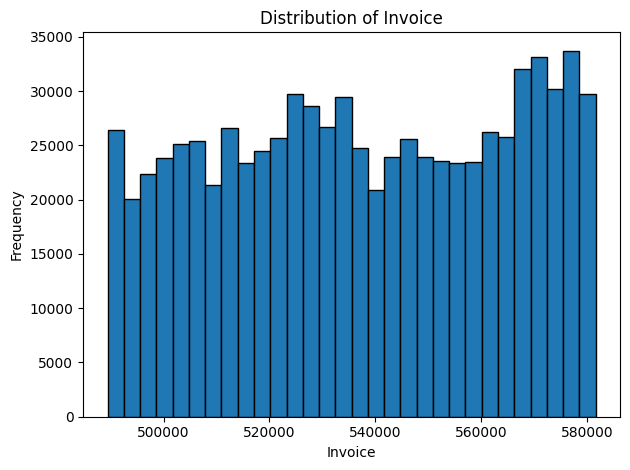

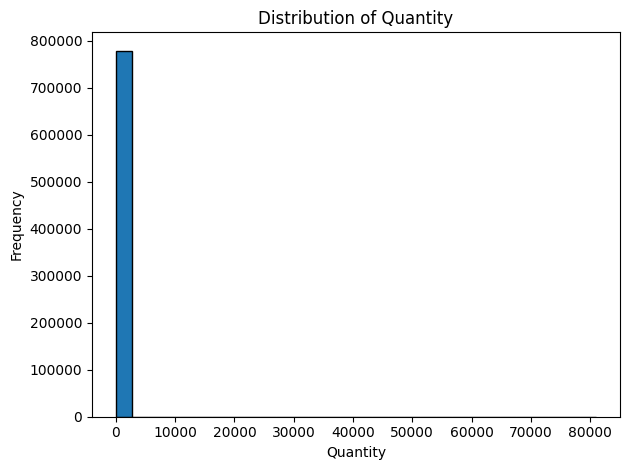

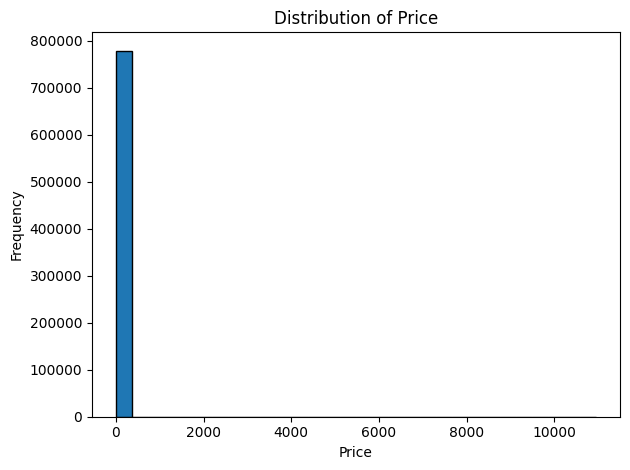

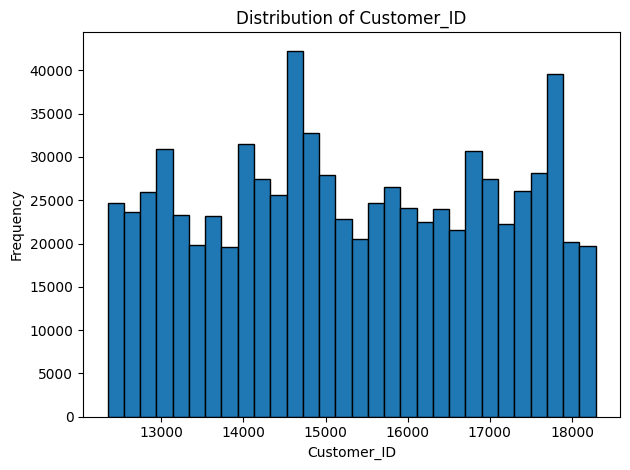

In [7]:
# Histogram Plot for Numeric Datatypes
numeric_cols=df.select_dtypes(include="number").columns
for col in numeric_cols:
    plt.figure()
    plt.hist(df[col],bins=30,histtype="bar",edgecolor="black")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

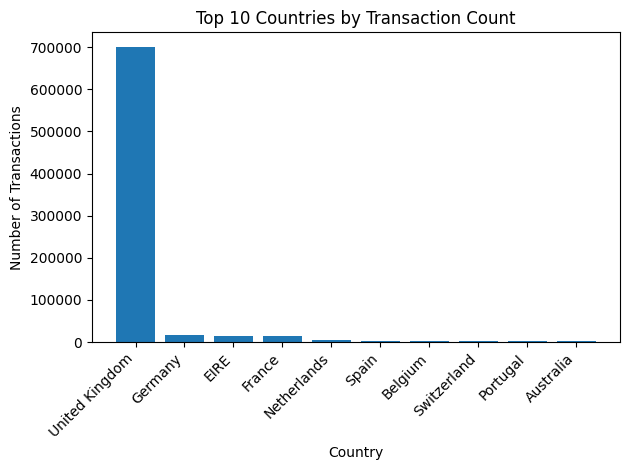

In [8]:
# Bar chart of top 10 countries by number of transactions
top_countries=df["Country"].value_counts().head(10)
plt.figure()
plt.bar(top_countries.index,top_countries.values)
plt.title("Top 10 Countries by Transaction Count")
plt.xlabel("Country")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

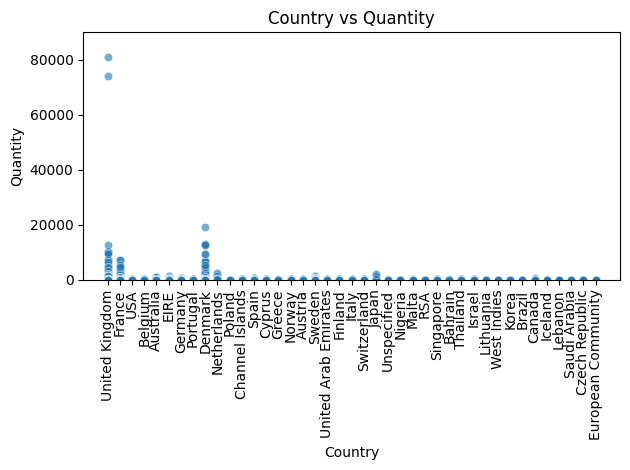

In [9]:
# Scatter plot of Country vs Quantity
plt.figure()
sns.scatterplot(data=df,x="Country",y="Quantity",alpha=0.6)
plt.ylim(0,90000)
plt.xticks(rotation=90)
plt.title("Country vs Quantity")
plt.tight_layout()
plt.show()

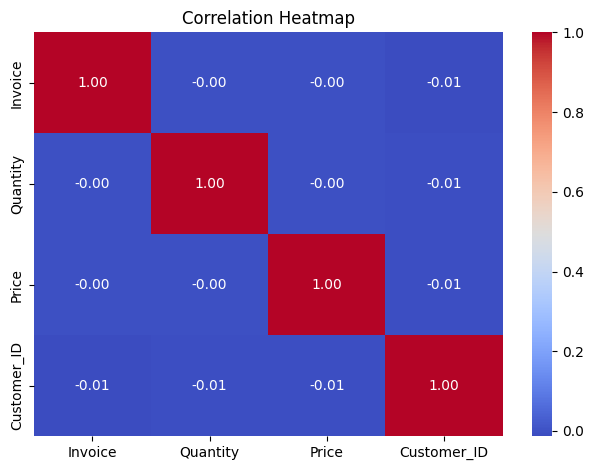

In [10]:
# Correlation Heatmap for numeric features only
plt.figure()
sns.heatmap(corr,annot=True,fmt=".2f",cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

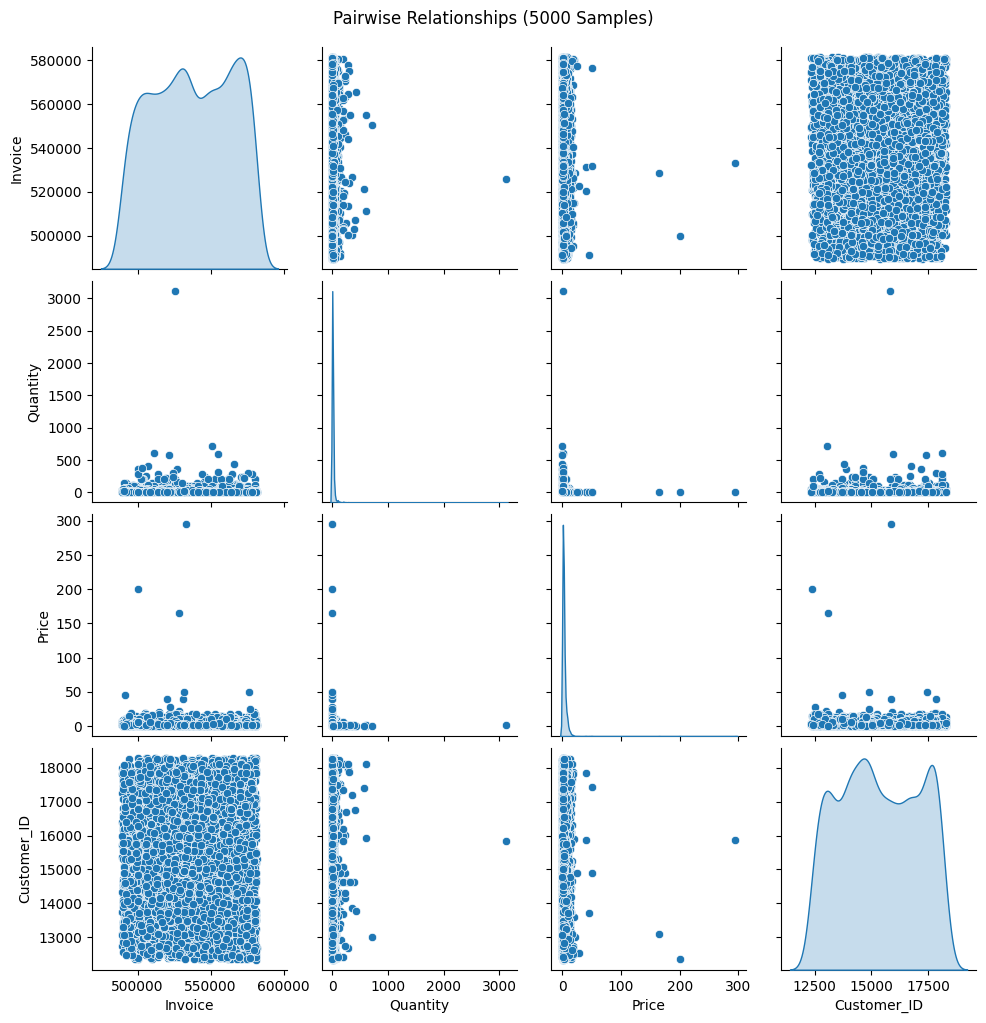

In [11]:
# Pairwise Relationships (5000 Samples)
sample=df[numeric_cols].sample(5000,random_state=42)
sns.pairplot(sample,diag_kind="kde")
plt.suptitle("Pairwise Relationships (5000 Samples)",y=1.02)
plt.show()

In [12]:
# Encoding categorical features
le=LabelEncoder()
for col in df.select_dtypes(include=["object"]).columns:
    df[col]=le.fit_transform(df[col])

In [13]:
# Building RFM tabel
# Recency: days since last invoice
today=df["InvoiceDate"].max()+pd.Timedelta(days=1)
r_user=df.groupby("Customer_ID")["InvoiceDate"].max().reset_index()
r_user["Recency"]=(today-r_user["InvoiceDate"]).dt.days

# Frequency: number of unique invoices
f_user=df.groupby("Customer_ID")["Invoice"].nunique().reset_index()
f_user.rename(columns={"Invoice":"Frequency"},inplace=True)

# Monetary: total spend per user
df["Revenue"]=df["Quantity"]*df["Price"]
m_user=df.groupby("Customer_ID")["Revenue"].sum().reset_index()
m_user.rename(columns={"Revenue":"Monetary"},inplace=True)

# Computing RFM scores
rfm=r_user.merge(f_user,on="Customer_ID").merge(m_user,on="Customer_ID")
rfm=rfm[["Recency","Frequency","Monetary"]]
rfm["RFM_Score"]=rfm.sum(axis=1)
print("Sample RFM scores:")
print(rfm.head(),"\n")

Sample RFM scores:
   Recency  Frequency  Monetary  RFM_Score
0      326         12  77556.46   77894.46
1        2          8   4921.53    4931.53
2       75          5   2019.40    2099.40
3       19          4   4428.69    4451.69
4      310          1    334.40     645.40 



In [14]:
# Feature scaling
scaler_std=StandardScaler()
X_std=scaler_std.fit_transform(rfm)

In [15]:
# Dimensionality Reduction
# PCA (retain 3 components)
pca=PCA(n_components=3,random_state=42)
X_pca=pca.fit_transform(X_std)
print("Explained variance ratio per PC:",pca.explained_variance_ratio_,"\n")

Explained variance ratio per PC: [0.64151826 0.24715399 0.11132775] 



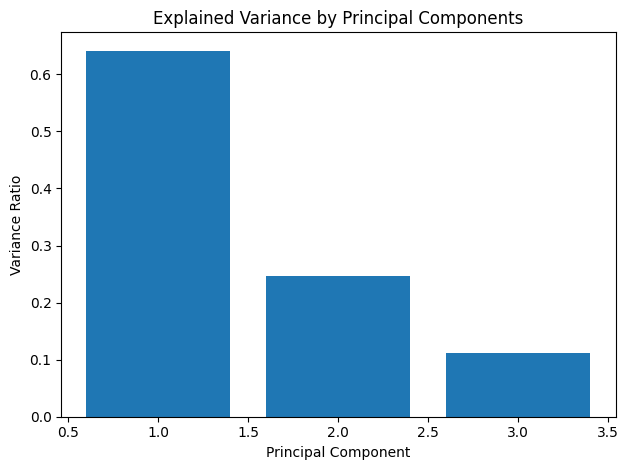

In [16]:
# Ploting explained variance
plt.figure()
plt.bar(range(1,4),pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.tight_layout()
plt.show()

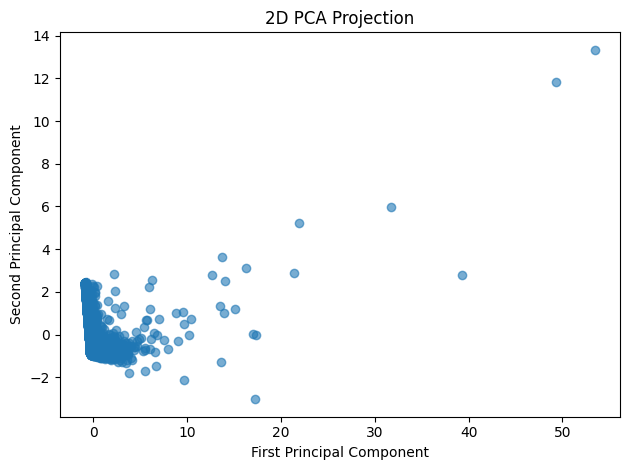

In [17]:
# 2D PCA projection
plt.figure()
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.6)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("2D PCA Projection")
plt.tight_layout()
plt.show()

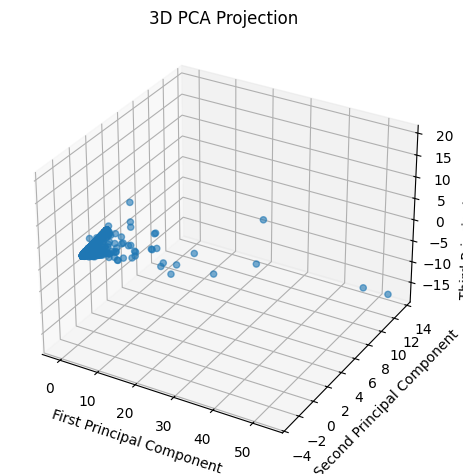

In [18]:
# 3D PCA projection
fig=plt.figure()
ax=fig.add_subplot(111,projection="3d")
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],alpha=0.6)
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_zlabel("Third Principal Component")
ax.set_title("3D PCA Projection")
plt.tight_layout()
plt.show()

Executing t-SNE:


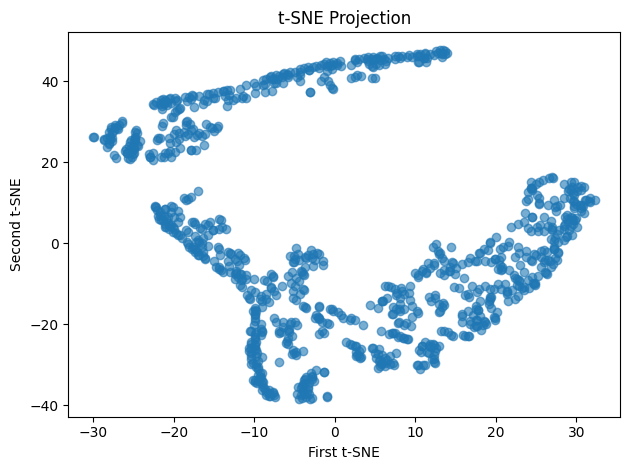

In [19]:
# t-SNE (sample if large)
if X_std.shape[0]>1000:
    idx=np.random.choice(X_std.shape[0],1000,replace=False)
    X_tsne_input=X_std[idx]
else:
    X_tsne_input=X_std
print("Executing t-SNE:")
X_tsne=TSNE(n_components=2,random_state=42).fit_transform(X_tsne_input)
plt.figure()
plt.scatter(X_tsne[:,0],X_tsne[:,1],alpha=0.6)
plt.xlabel("First t-SNE")
plt.ylabel("Second t-SNE")
plt.title("t-SNE Projection")
plt.tight_layout()
plt.show()

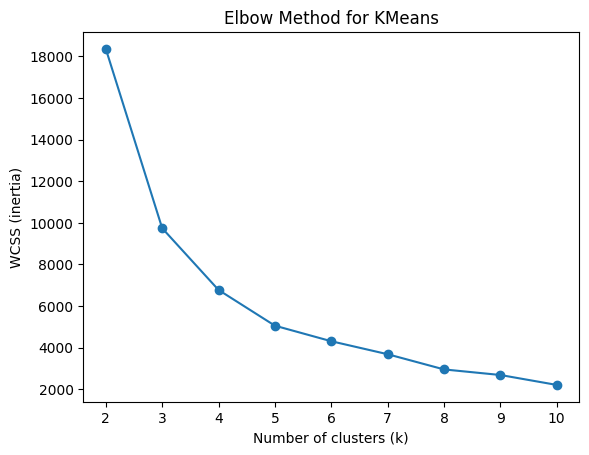

In [20]:
# Clustering Pipeline
# Elbow method for KMeans
wcss=[]
for k in range(2,11):
    km=KMeans(n_clusters=k,random_state=42).fit(X_std)
    wcss.append(km.inertia_)
plt.figure()
plt.plot(range(2,11),wcss,marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (inertia)")
plt.title("Elbow Method for KMeans")
plt.show()

In [21]:
# Estimating MeanShift bandwidth based on quantile
bw=estimate_bandwidth(X_std,quantile=0.995,random_state=42)

# Estimating DBSCAN eps via k-distance (k=5) and 90th percentile knee
nbrs=NearestNeighbors(n_neighbors=5).fit(X_std)
distances,_=nbrs.kneighbors(X_std)
sorted_dist=np.sort(distances[:,-1])
eps_est=np.percentile(sorted_dist,93)

# Estimating BIRCH threshold as 50th percentile of pairwise distances
pdists=pairwise_distances(X_std)
thresh=np.percentile(pdists,25)

In [22]:
# Defining clustering models
cluster_models={
    "KMeans": lambda: KMeans(n_clusters=4,random_state=42),
    "MeanShift": lambda: MeanShift(bandwidth=bw),
    "DBSCAN": lambda: DBSCAN(eps=eps_est,min_samples=5),
    "Hierarchical": lambda: AgglomerativeClustering(n_clusters=4,linkage="ward"),
    "GMM": lambda: GaussianMixture(n_components=4,covariance_type="full",random_state=42),
    "BIRCH": lambda: Birch(n_clusters=4,threshold=thresh)
}

Executing KMeans


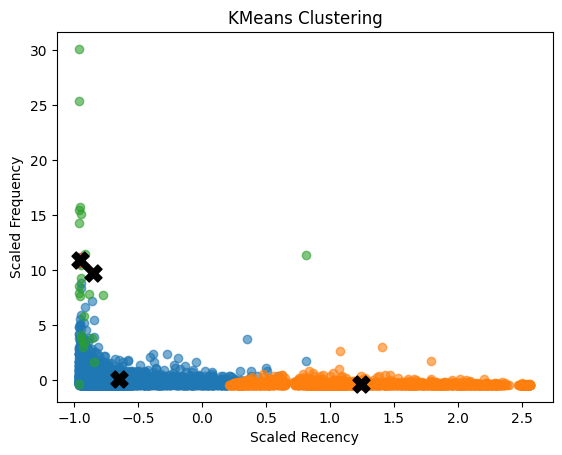

Cluster Summary for KMeans:
            Recency   Frequency       Monetary      RFM_Score
Cluster                                                      
0         65.959343    7.605682    3084.977640    3158.542664
1        461.192670    2.196137     741.897758    1205.286564
2         23.304348  133.086957  127402.779652  127559.170957
3          1.500000  148.500000  554794.780000  554944.780000 

Executing MeanShift


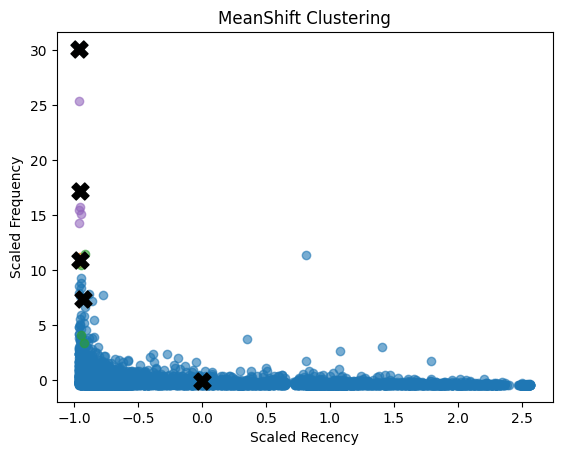

Cluster Summary for MeanShift:
           Recency   Frequency       Monetary      RFM_Score
Cluster                                                     
0        201.86335    5.915659    2499.127429    2706.906437
1          1.50000  148.500000  554794.780000  554944.780000
2          6.25000  102.500000  231498.857500  231607.607500
3          1.00000  398.000000  291420.810000  291819.810000
4          1.60000  230.200000   76083.918000   76315.718000 

Executing DBSCAN


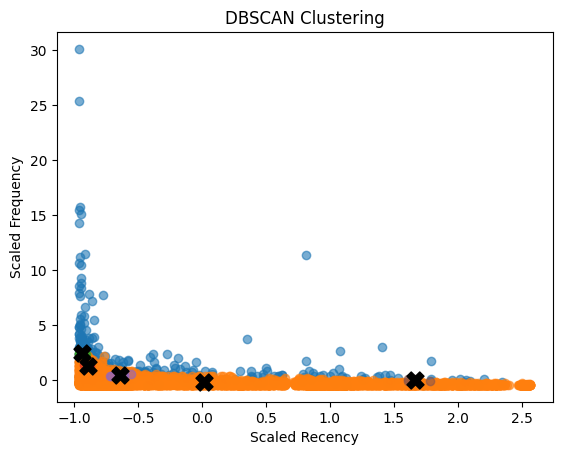

Cluster Summary for DBSCAN:
            Recency  Frequency      Monetary     RFM_Score
Cluster                                                   
0        205.602059   4.638909   1544.452864   1754.693832
1          5.000000  38.166667   9161.118333   9204.285000
2         15.000000  23.250000  13770.997500  13809.247500
3         67.200000  12.800000   9638.046000   9718.046000
4        550.200000   7.000000   2620.078000   3177.278000 

Executing Hierarchical


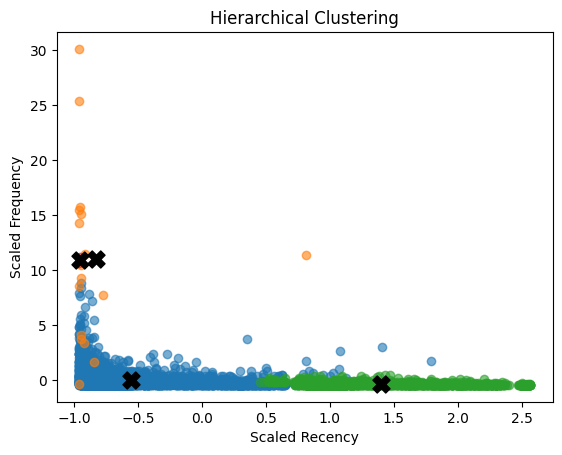

Cluster Summary for Hierarchical:
            Recency   Frequency       Monetary      RFM_Score
Cluster                                                      
0         84.616818    7.325609    3031.157171    3123.099598
1         28.176471  150.058824  145328.532941  145506.768235
2        495.277446    2.065632     660.027286    1157.370365
3          1.500000  148.500000  554794.780000  554944.780000 

Executing GMM


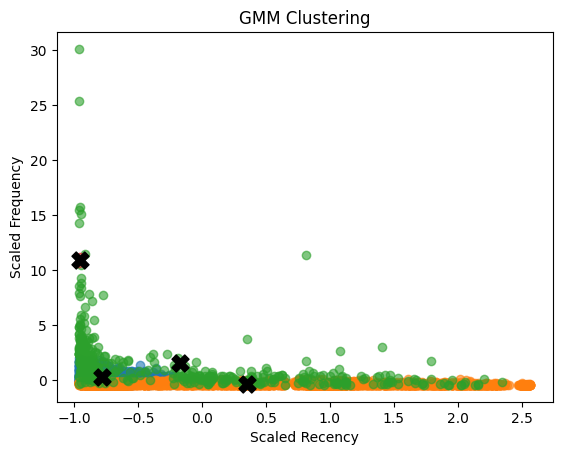

Cluster Summary for GMM:
            Recency   Frequency       Monetary      RFM_Score
Cluster                                                      
0         38.033028   10.007951    3624.323509    3672.364487
1        275.531798    2.282649     603.750111     881.564557
2        164.962175   27.406619   18989.400939   19181.769733
3          1.500000  148.500000  554794.780000  554944.780000 

Executing BIRCH


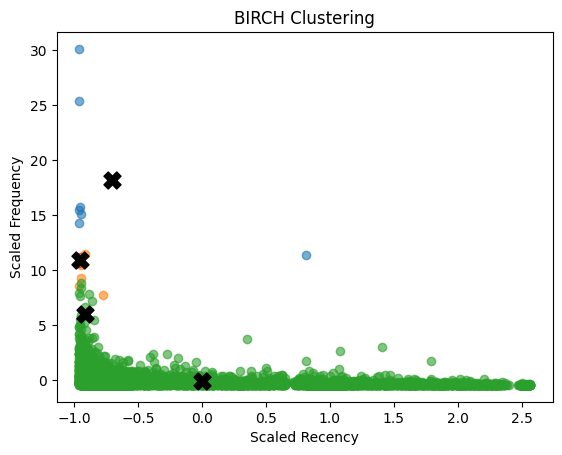

Cluster Summary for BIRCH:
            Recency   Frequency       Monetary      RFM_Score
Cluster                                                      
0         54.428571  243.428571  103292.752857  103590.610000
1          9.800000   84.700000  174753.579000  174848.079000
2        202.028489    5.821733    2353.229213    2561.079435
3          1.500000  148.500000  554794.780000  554944.780000 



In [23]:
# Fitting, ploting, and evaluating each clustering model
evaluation=[]
for name, ctor in cluster_models.items():
    print(f"Executing {name}")
    model=ctor() if callable(ctor) else ctor
    labels=model.fit_predict(X_std)

    # Computing centroids per cluster
    unique_labels=np.unique(labels)
    centroids=np.array([X_std[labels==lbl].mean(axis=0) for lbl in unique_labels if lbl!=-1])

    # 2D scatter on first two scaled RFM features
    plt.figure()
    for lbl in unique_labels:
        mask=(labels==lbl)
        plt.scatter(X_std[mask,0],X_std[mask,1],label=f"Cluster {lbl}",alpha=0.6)
    plt.scatter(centroids[:,0],centroids[:,1],marker="X",s=150,c="black",label="Centroids")
    plt.xlabel("Scaled Recency")
    plt.ylabel("Scaled Frequency")
    plt.title(f"{name} Clustering")
    plt.show()

    # Evaluation metrics
    sil=silhouette_score(X_std[labels!=-1],labels[labels!=-1]) if len(unique_labels) > 1 else np.nan
    db=davies_bouldin_score(X_std[labels!=-1],labels[labels!=-1]) if len(unique_labels) > 1 else np.nan
    ch=calinski_harabasz_score(X_std[labels!=-1],labels[labels!=-1]) if len(unique_labels) > 1 else np.nan
    inertia=getattr(model,"inertia_",np.nan)
    evaluation.append({"Algorithm":name,"Silhouette":sil,"Davies-Bouldin":db,"Calinski-Harabasz":ch,"WCSS":inertia})

    # Cluster summary (using RFM)
    rfm_with_labels=rfm.copy()
    rfm_with_labels["Cluster"]=labels
    summary=rfm_with_labels[rfm_with_labels["Cluster"]!=-1].groupby("Cluster").mean()
    print(f"Cluster Summary for {name}:")
    print(summary,"\n")

In [24]:
results_df=pd.DataFrame(evaluation)
print("Clustering Evaluation Metrics:")
print(results_df,"\n")

Clustering Evaluation Metrics:
      Algorithm  Silhouette  Davies-Bouldin  Calinski-Harabasz        WCSS
0        KMeans    0.571342        0.525246        4841.983170  6776.04431
1     MeanShift    0.919838        0.411019        1475.128157         NaN
2        DBSCAN   -0.178335        0.651252          18.151969         NaN
3  Hierarchical    0.555269        0.519918        4480.558656         NaN
4           GMM    0.188968        1.119766        1561.604062         NaN
5         BIRCH    0.918530        0.686920        2158.340030         NaN 



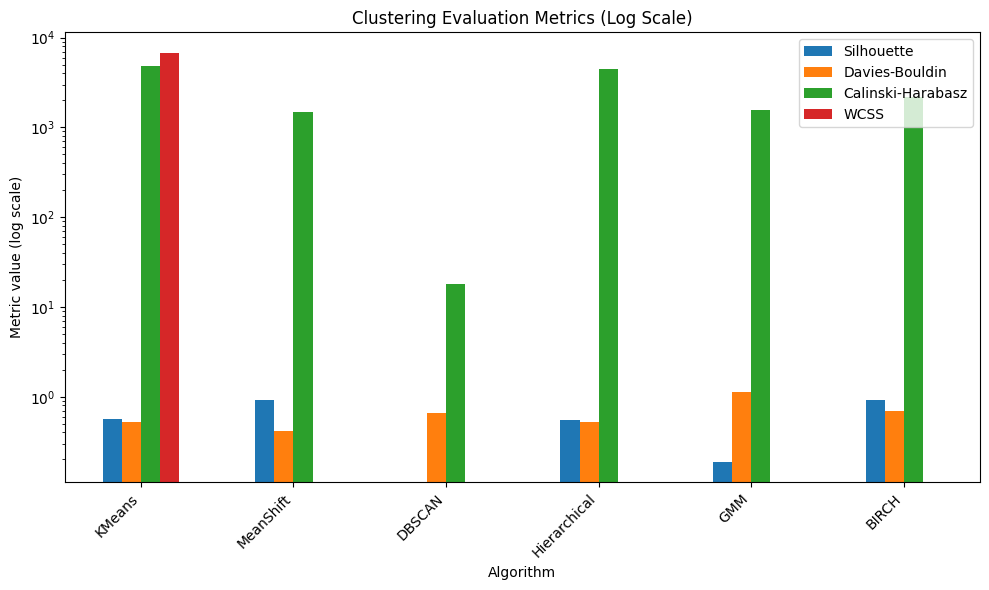

In [25]:
# Plot evaluation metrics
plot_df=results_df.set_index("Algorithm")
plot_df.plot(kind="bar",logy=True,figsize=(10,6))
plt.title("Clustering Evaluation Metrics (Log Scale)")
plt.ylabel("Metric value (log scale)")
plt.xlabel("Algorithm")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [26]:
# Selecting best algorithm
results_df["rank_sil"]=results_df["Silhouette"].rank(ascending=False)
results_df["rank_db"]=results_df["Davies-Bouldin"].rank(ascending=True)
results_df["rank_ch"]=results_df["Calinski-Harabasz"].rank(ascending=False)
if results_df["WCSS"].dropna().empty:
    results_df["rank_wcss"]=np.nan
else:
    results_df["rank_wcss"]=results_df["WCSS"].rank(ascending=True)
results_df["rank_sum"]=results_df[["rank_sil","rank_db","rank_ch","rank_wcss"]].sum(axis=1,skipna=True)
best_row=results_df.loc[results_df["rank_sum"].idxmin()]
best_algo=best_row["Algorithm"]
print(f"Best algorithm:{best_algo}\n")

Best algorithm:MeanShift



In [27]:
# Assigning final cluster labels
best_model=cluster_models[best_algo]()
best_labels=best_model.fit_predict(X_std)
user_cluster_map=rfm.copy()
user_cluster_map["Cluster"]=best_labels
if "Customer_ID" not in user_cluster_map.columns:
    user_cluster_map=user_cluster_map.reset_index()
    if "Customer_ID" not in user_cluster_map.columns:
         user_cluster_map=user_cluster_map.merge(r_user[["Customer_ID"]].reset_index(),left_index=True,right_index=True)
         user_cluster_map = user_cluster_map.drop(columns=["index_x","index_y"])
if "Cluster" in df.columns:
    df=df.drop("Cluster",axis=1)
df=df.merge(user_cluster_map,on="Customer_ID",how="left")

In [28]:
# Final profiling using the best algorithm labels
final_profile=df.groupby("Cluster").mean(numeric_only=True)
print(f"Final Cluster Profile (by {best_algo} Algorithm):")
print(final_profile)

Final Cluster Profile (by MeanShift Algorithm):
               Invoice    StockCode  Description    Quantity     Price  \
Cluster                                                                  
0        537372.617592  1858.549888  2737.987909   12.535054  3.201475   
1        536882.299346  1747.496526  2750.146302  112.275848  2.734493   
2        530275.069717  1875.631787  2726.951950   70.642620  4.133700   
3        539528.741673  1900.148660  2726.459699   13.378644  5.134547   
4        539693.445899  1818.379905  2758.191983    6.605400  2.795170   

          Customer_ID    Country     Revenue    Recency   Frequency  \
Cluster                                                               
0        15325.799833  36.223754   20.296011  88.930274   17.001248   
1        15380.417654  26.975072  226.724471   1.787495  150.512464   
2        15042.073923  23.589600  118.021340   7.064491  124.993118   
3        14911.000000  10.000000   26.303891   1.000000  398.000000   
4      